In [1]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [2]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
import glob
import time
import os
import scipy

In [3]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

Using gpu device 0: GeForce GT 630M (CNMeM is disabled, CuDNN not available)
/home/igor/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')

Using lasagne.layers (slower)


In [6]:
region_width = 28
region_height = 28
frameMult = 1
l_rw=region_width*frameMult
l_rh=region_height*frameMult
l_rS=l_rw*l_rh
l_colors=3



In [7]:
def load_mnist(fname = 'mnist.pkl.gz'):
    if not os.path.isfile(fname):
        try:
            testfile = urllib.request.URLopener()
        except:
            testfile = urllib.URLopener()
        testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
    f = gzip.open(fname, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()
    Xmono, y = train_set
    Xmono_test=test_set
###############################
    Xcolor_test1=[]
    i=-1
    for pict in Xmono_test[0]:
        i+=1
        d1=np.rollaxis(np.array(zip(pict,pict,pict)).reshape(l_rw,l_rh,3), 2, 0)
        Xcolor_test1.extend([d1])
    Xcolor_test1=np.asarray(Xcolor_test1, dtype=np.float32)                   


    Xcolor1=[]
    ycolor1=[]
    i=-1
    for pict in Xmono:
        i+=1
        if y[i]<=3 :
            d=np.rollaxis(np.array(zip(pict,[0]*l_rS,[0]*l_rS)).reshape(l_rw,l_rh,l_colors), 2, 0)
        elif y[i]<=7:
            d=np.rollaxis(np.array(zip([0]*l_rS,pict,[0]*l_rS)).reshape(l_rw,l_rh,l_colors), 2, 0)
        else:  
            d=np.rollaxis(np.array(zip([0]*l_rS,[0]*l_rS,pict)).reshape(l_rw,l_rh,l_colors), 2, 0)
        ycolor1.extend([d])
        d1=np.rollaxis(np.array(zip(pict,pict,pict)).reshape(l_rw,l_rh,l_colors), 2, 0)
        Xcolor1.extend([d1])
    Xcolor1=np.asarray(Xcolor1, dtype=np.float32)
    ycolor1=np.asarray(ycolor1, dtype=np.float32)

    X_out1 = ycolor1.reshape((Xcolor1.shape[0], -1))
    return Xcolor1,X_out1,Xcolor_test1 
    
    

In [10]:
Xcolor,X_out,Xcolor_test=load_mnist()

In [11]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
#encode_size = 32
#dense_mid_size = 256
pad_in = 'valid'
pad_out = 'full'
dense_last_layer=((Xcolor.shape[2]-2*(filter_size-1))/pool_size-(filter_size-1))/pool_size
layers = [
    (InputLayer, {'shape': (None, Xcolor.shape[1], Xcolor.shape[2], Xcolor.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    #(DenseLayer, {'num_units': 800}),
    #(ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (DenseLayer, {'num_units': 2*conv_num_filters*dense_last_layer* dense_last_layer}),
    
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, dense_last_layer, dense_last_layer))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': l_colors, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [12]:
ae = NeuralNet(
    layers=layers,
    max_epochs=20,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [13]:
ae.fit(Xcolor, X_out)

# Neural Network with 224755 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  input0       3x28x28
  1  conv2d1      16x26x26
  2  conv2d2      16x24x24
  3  maxpool2d3   16x12x12
  4  conv2d4      32x10x10
  5  maxpool2d5   32x5x5
  6  reshape6     800
  7  dense7       128
  8  encode       16
  9  dense9       128
 10  dense10      800
 11  reshape11    32x5x5
 12  upscale2d12  32x10x10
 13  conv2d13     16x12x12
 14  upscale2d14  16x24x24
 15  conv2d15     16x26x26
 16  conv2d16     3x28x28
 17  reshape17    2352

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -------
      1       0.03255       0.03125      1.04160  513.75s
      2       0.03059       0.02931      1.04372  422.42s
      3       0.02714       0.02433      1.11544  423.46s
      4       0.02323       0.02156      1.07741  495.49s
      5       0.02086       0.01937      1.07714  452.75s
      6       0.01865   

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8efda9f690>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f8efda9f590>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 3, 28, 28)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne....d': 'full', 'num_filters': 3}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x7f8efdaa5050>,
     objective_loss_function=<function squared_error at 0x7f8efdf84cf8>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f8efda61b48>],
     on_training_finished=[],
     on_training_st

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

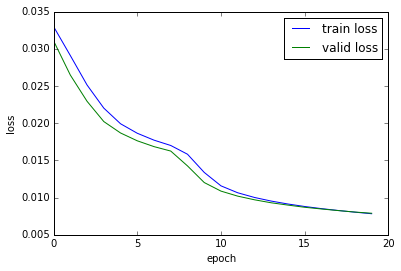

In [90]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

In [14]:
# ae.save_params_to('mnist/conv_ae.np')
pickle.dump(ae, open('conv_ae_mnist.pkl','wb'))

# ae.layers

In [15]:
#X_pred = ae.predict(Xcolor).reshape(-1,3, 28, 28)
import time
X_test = np.rint(256. * Xcolor_test).astype(int)
X_test = np.clip(X_test, a_min = 0, a_max = 255)
X_test = X_test.astype('uint8')

start_time = time.time()
X_pred = ae.predict(Xcolor_test).reshape(-1,3, 28, 28)
print("took {:.3f}s".format(time.time() - start_time))
X_pred = np.rint(256. * X_pred).astype(int)
X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
X_pred = X_pred.astype('uint8')



print(X_pred.shape, Xcolor_test.shape , Xcolor.shape,X_test.shape)

took 37.511s
(10000, 3, 28, 28) (10000, 3, 28, 28) (50000, 3, 28, 28) (10000, 3, 28, 28)


Populating the interactive namespace from numpy and matplotlib


/opt/extra/ipython/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['tanh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


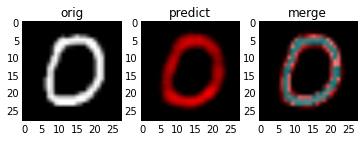

In [16]:
%pylab inline
nn=10
orig1=np.rollaxis(X_test[nn], 0, 3)
reg1=np.rollaxis(X_pred[nn] , 0, 3)
d_in2=orig1.reshape(orig1.shape[0]*orig1.shape[1],orig1.shape[2])
d_out2=reg1.reshape(reg1.shape[0]*reg1.shape[1],reg1.shape[2])




d_out3=[]
for ii in range (d_out2.shape [0]):
    #dres=d_in2[ii]
    #dres=d_out2[ii]
    #print(ii,d_in2[ii].shape)
    #print (d_in2[ii])
    if ((d_out2[ii][0]>150.7) and (d_in2[ii][0]<100.7) ):
        dres=d_out2[ii]
    else  :  
        dres=d_in2[ii]
    dres=d_out2[ii]+d_in2[ii]/2
    d_out3.extend([dres])
d_out4=np.array(d_out3).reshape(reg1.shape[0],reg1.shape[1],reg1.shape[2])


sub1 = plt.subplot(1, 3, 1)
plt.imshow( orig1)
sub1.set_title("orig")

sub2 = plt.subplot(1, 3, 2)
plt.imshow(reg1)
sub2.set_title("predict")

sub3 = plt.subplot(1, 3, 3)
plt.imshow(d_out4)
sub3.set_title("merge")


#print (np.clipoi_a)

In [ ]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

In [ ]:
def get_output_from_nn(last_layer, X):
    return get_output(last_layer,X).eval()

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

#X_decoded = 256 * decode_encoded_input(X_encoded[2])
X_decoded = 256 * decode_encoded_input(X_encoded[np.random.randint(10000)])


X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print(X_decoded.shape)
dd2=np.rollaxis(X_decoded.reshape(3,28,28), 0, 3)
print(dd2.shape)
pic_array = get_picture_arrayC(X_decoded)
print (pic_array.shape)
#image = Image.fromarray(pic_array,'RGB')
#imshow(np.rollaxis(X_decoded.reshape(3,28,28), 0, 3))
#image.save('data/test.png', format="PNG")  
#IPImage('data/test.png')


In [ ]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [ ]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i], rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

In [ ]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')